In [72]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Tweets Classification** 

---



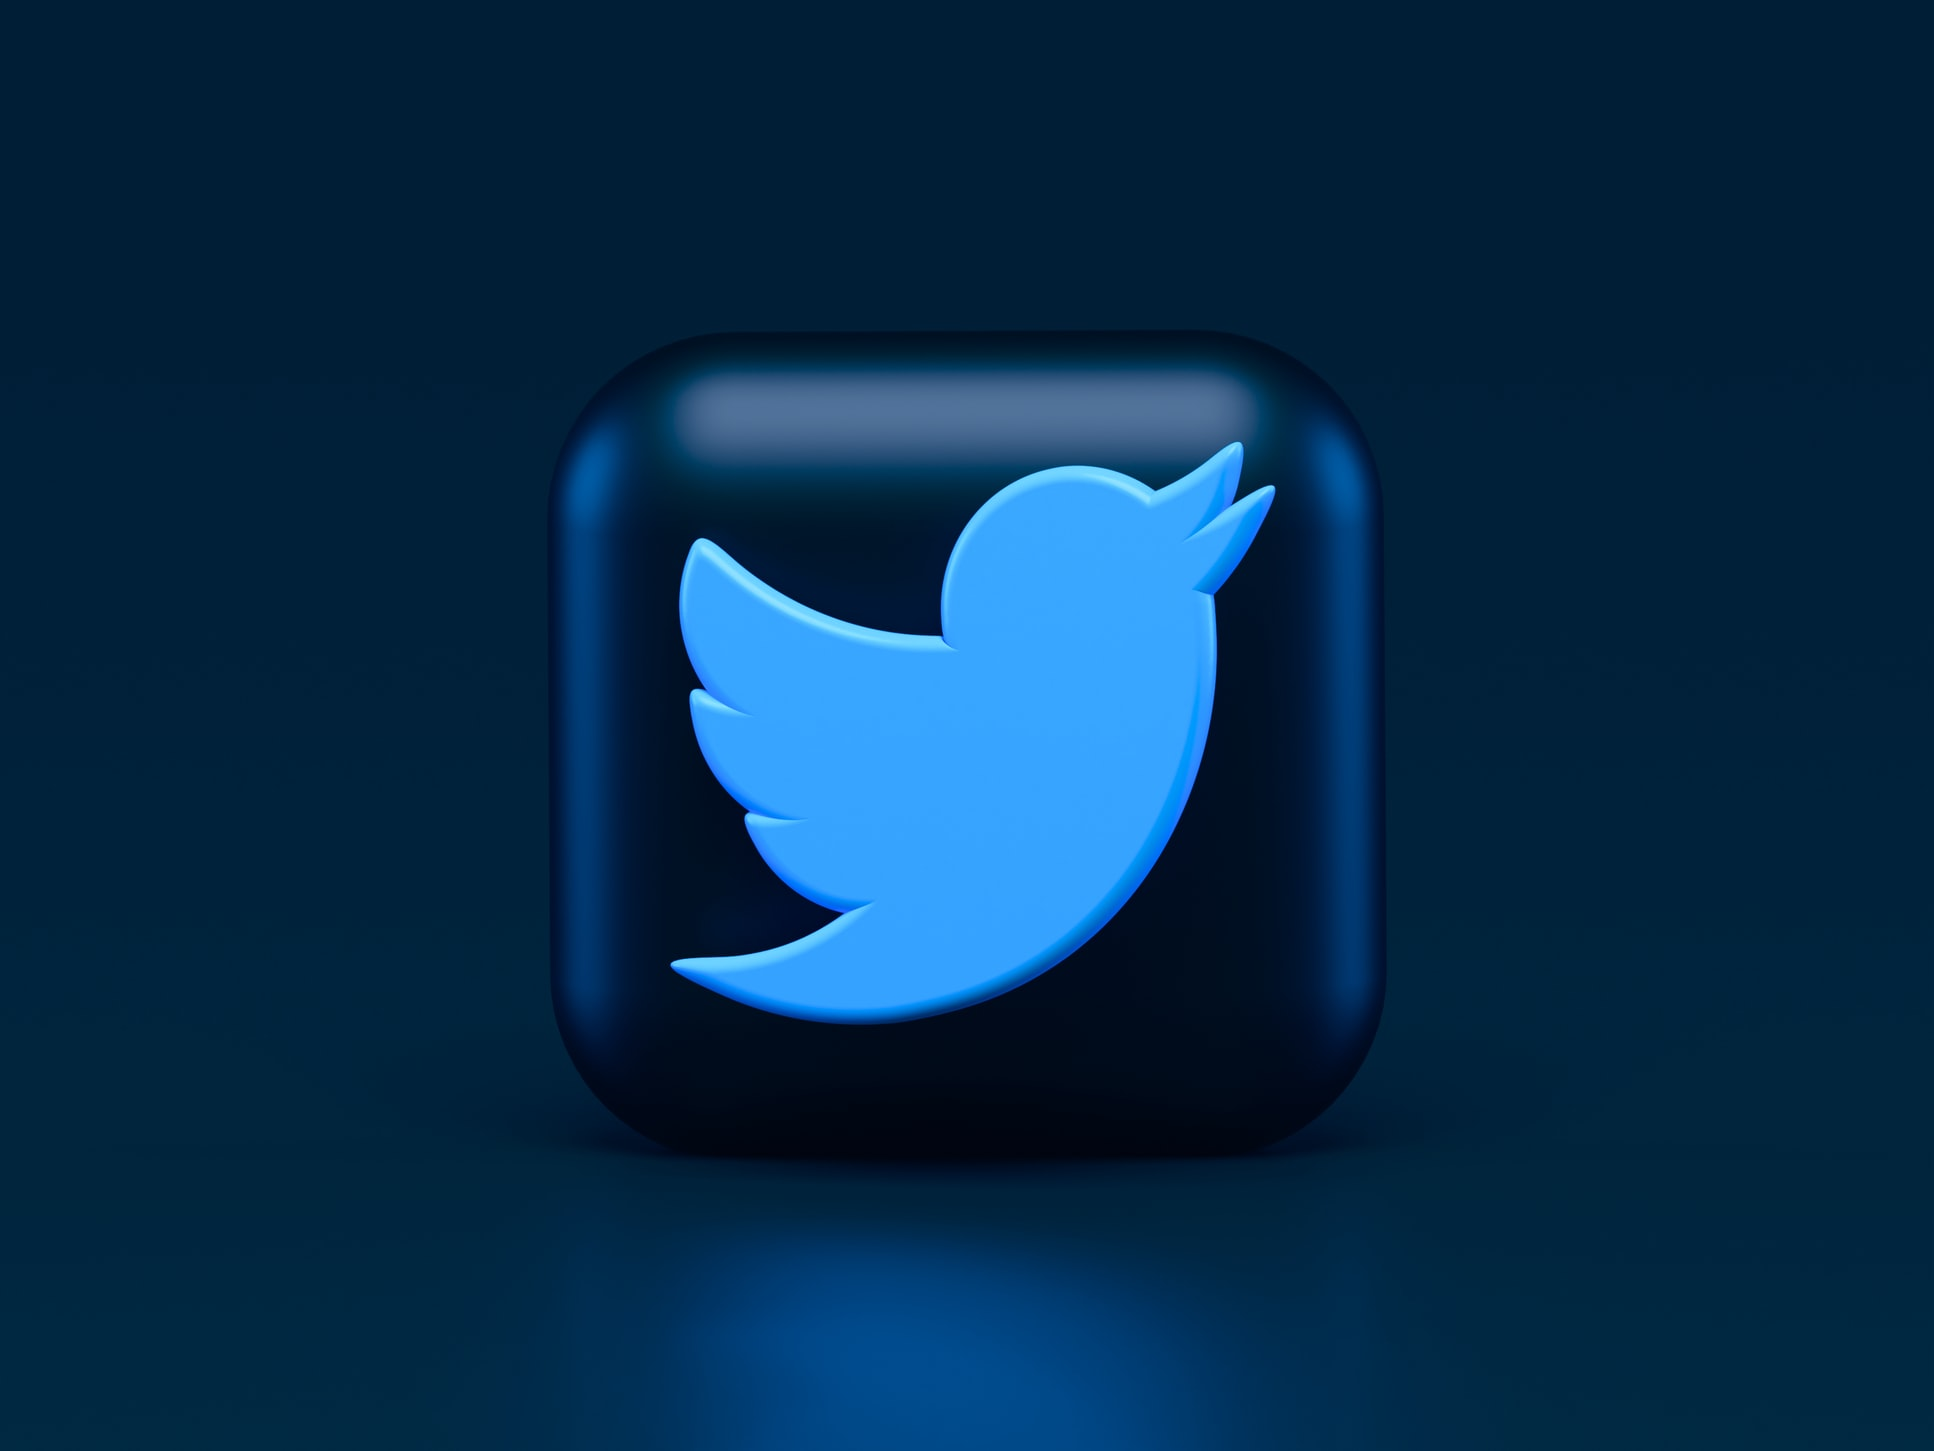

# **Contents:**

---


* ***Problem Statement***
* ***About the dataset***
* ***Exploratory Data Analysis*** 
* ***Data Analysis***
* ***Data Preprocessing***
* ***ML Model***  
* ***Why BERT Model***
* ***Create the Model***
* ***Model Training***
* ***Model Prediction***
* ***Logisitic Regression Model***
* ***AutoML Model***
* ***Conclusion*** 


# **Problem Statement:** 
The goal is to predict whether the given tweet is a about a real disaster or not. If it is real disaster then the prediction should be 1 and if not not then 0.

# **About the dataset:**

The features in the dataset are as follows

**id** - an identifier for each tweet

**keyword** - a particular keyword from the tweet

**location** - the location the tweet was sent from 

**text** - the text of the tweet

**target** - the output that tells if a tweet is about a real disaster (1) or not (0)

**random** - this column contains random numbers and again all values are unique.

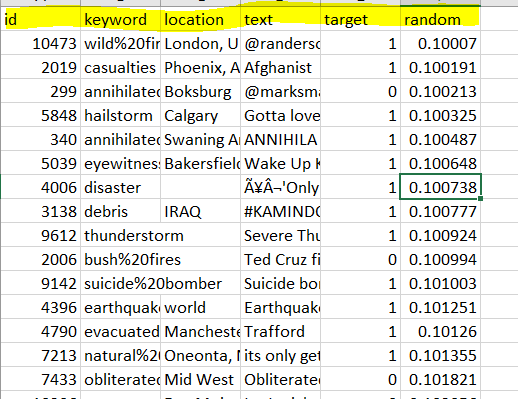

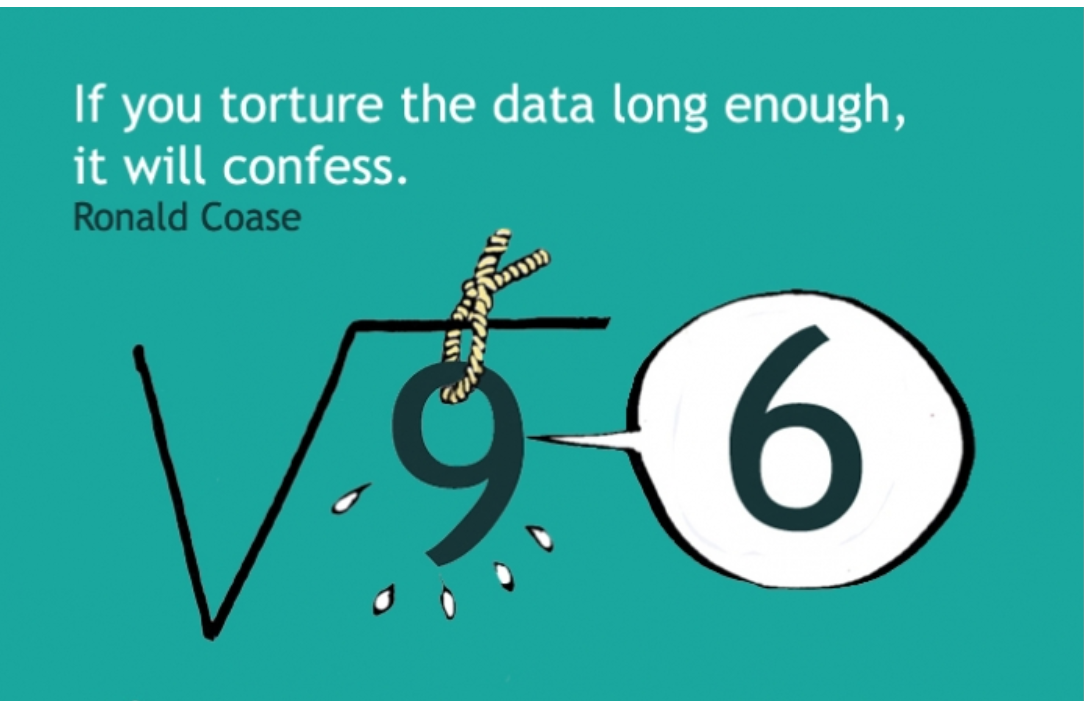

**PIP Install all the required libraries**

---



In [73]:
#PIP Install all the required libraries
!pip install tokenization wordcloud tqdm transformers nltk tensorflow_hub 

In [74]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Import all the required libraries**

---



In [75]:
#Import all the libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
import tokenization
from wordcloud import STOPWORDS
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from wordcloud import WordCloud
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string


In [76]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer

import warnings
warnings.filterwarnings('ignore')

**Load the training data set**: Load the traning CSV file into pandas dataframe.

---



In [78]:
#Load the file.

tweets = pd.read_csv('/content/drive/MyDrive/train_set.csv', dtype={'id': np.int16, 'target': np.int8})

df_test = pd.read_csv('/content/drive/MyDrive/test01.csv')




**Describe the pandas dataframe**

---



In [79]:
#Analyze the dataframe
tweets.describe

<bound method NDFrame.describe of          id       keyword        location                                               text  target    random
0     10473  wild%20fires      London, UK  @randerson62 Watching news of wild fires and h...       1  0.100070
1      2019    casualties     Phoenix, AZ  Afghanistan: U.N. Reports 'Record-High Levels'...       1  0.100191
2       299   annihilated        Boksburg  @marksmaponyane Hey!Sundowns were annihilated ...       0  0.100213
3      5848     hailstorm         Calgary  Gotta love #summer in #Calgary. #yyc #hailstor...       1  0.100325
4       340   annihilated  Swaning Around  ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS Û...       1  0.100487
...     ...           ...             ...                                                ...     ...       ...
6872   6376      hostages             NaN  One Year on from the Sinjar Massacre #Yazidis ...       1  0.999180
6873  10290        weapon             NaN  Fur Leather Coats sprite &amp; weap

**Check the header and tail**

---



In [80]:
tweets.head(10)

id       keyword                 location                                               text  target    random
0  10473  wild%20fires               London, UK  @randerson62 Watching news of wild fires and h...       1  0.100070
1   2019    casualties              Phoenix, AZ  Afghanistan: U.N. Reports 'Record-High Levels'...       1  0.100191
2    299   annihilated                 Boksburg  @marksmaponyane Hey!Sundowns were annihilated ...       0  0.100213
3   5848     hailstorm                  Calgary  Gotta love #summer in #Calgary. #yyc #hailstor...       1  0.100325
4    340   annihilated           Swaning Around  ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS Û...       1  0.100487
5   5039    eyewitness  Bakersfield, California  Wake Up Kern County Eyewitness News Mornings a...       1  0.100648
6   4006      disaster                      NaN  å¬'Only the sea knows how many are dead' @MSF_...       1  0.100738
7   3138        debris                     IRAQ  #KAMINDOZ #reuters Debris confirmed from MH370...       1  0.100777
8   9612  thunderstorm                      NaN  Severe Thunderstorm Warning issued August 05 a...       1  0.100924
9   2006  bush%20fires                      NaN  Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...       0  0.100994

In [81]:
tweets.tail(10)

id     keyword                      location                                               text  target    random
6867   1143      blight              Central Illinois  @todd_calfee so @mattburgener wanted to see th...       1  0.997934
6868   3879  detonation                      New York  Detonation fashionable mountaineering electron...       1  0.998323
6869  10677      wounds     Earth: Senseless nonsense  Explosion in Gaza Strip kills four wounds 30; ...       1  0.998513
6870   9723     tragedy                         India  Railways caught unawares by MP tragedy; Accide...       1  0.998857
6871   6009   hazardous  Muntinlupa City, Philippines  @HearItFromPatty Also pls help us w/ our campa...       0  0.999126
6872   6376    hostages                           NaN  One Year on from the Sinjar Massacre #Yazidis ...       1  0.999180
6873  10290      weapon                           NaN  Fur Leather Coats sprite &amp; weapon of choic...       0  0.999258
6874   3115      debris                           NaN  RÌ©union Debris Is Almost Surely From Flight 3...       1  0.999439
6875   9472   terrorism                        Riyadh  In #islam saving a person is equal in reward t...       1  0.999539
6876   3534  derailment                        Mumbai  Latest : Trains derailment: 'It's the freakies...       1  0.999615

# **Exploratory Data Anaysis(EDA)**

---



In [82]:
#Basic Exploratory Data Anaysis(EDA)
print('There are {} rows and {} columns in train'.format(tweets.shape[0],tweets.shape[1]))

There are 6877 rows and 6 columns in train


Text(0, 0.5, 'Tweets')

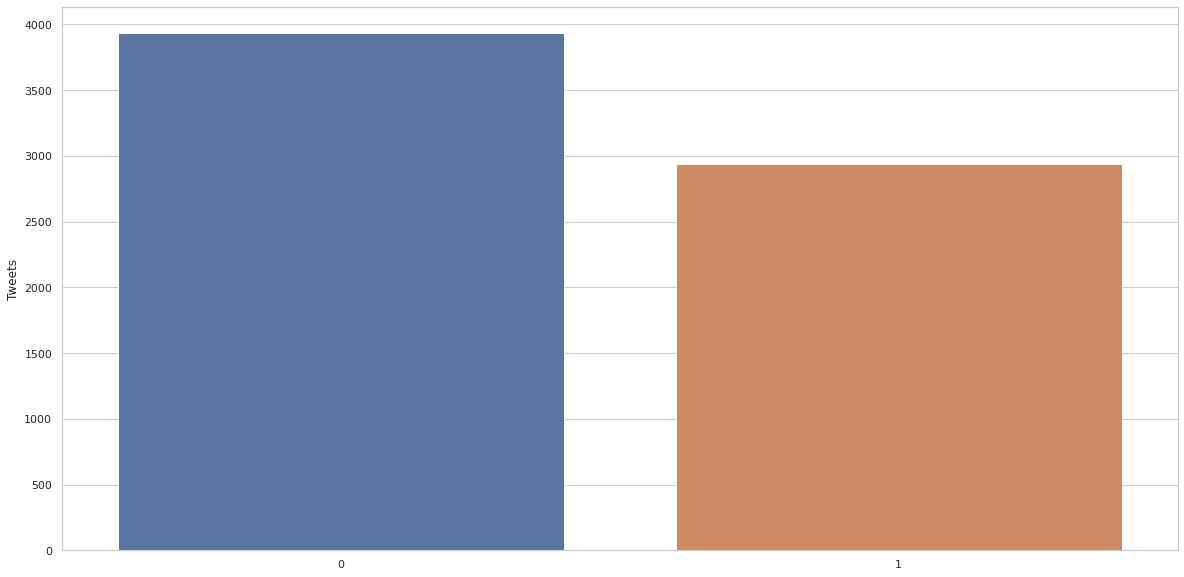

In [83]:
#First check the class distribution
x=tweets.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Tweets')

In [84]:
neg, pos = np.bincount(tweets['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)'.format(total, pos, 100 * pos / total,neg, 100 * neg / total))

Examples:
    Total: 6877
    Positive: 2940 (42.75% of total)
    Negative: 3937 (57.25% of total)


There is definitely imbalance in the dataset .
**Total: 6877**
    **Positive: 2940 (42.75% of total)**
    **Negative: 3937 (57.25% of total)**

The disaster tweets are 42.75% of the total tweets. The non disaster tweets are 57.25% of the toal. Still it is not a very bad imbalanced dataset.

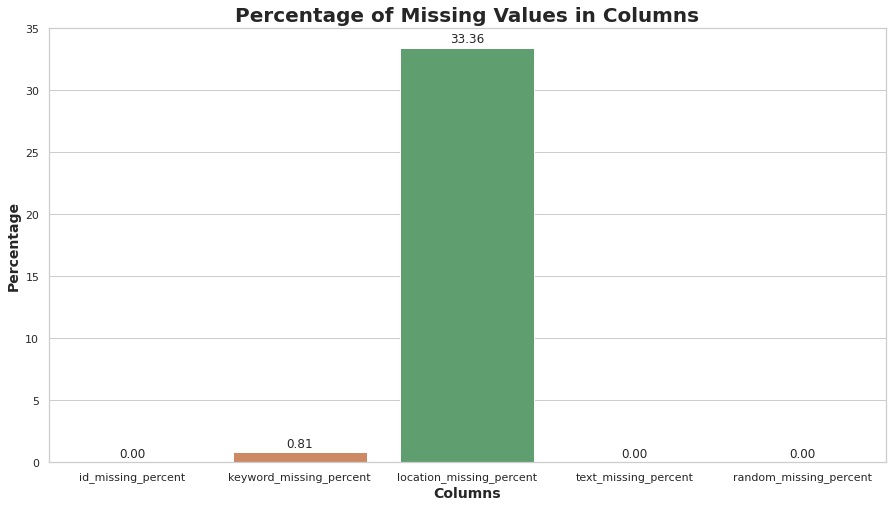

In [85]:
# creating a new dataframe for missing values percentage
missing_values = dict(zip([col+"_missing_percent" for col in tweets.columns if col != "target"],
                          [round(100*tweets[col].isnull().sum()/len(tweets), 2) for col in tweets.columns
                           if col != "target"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

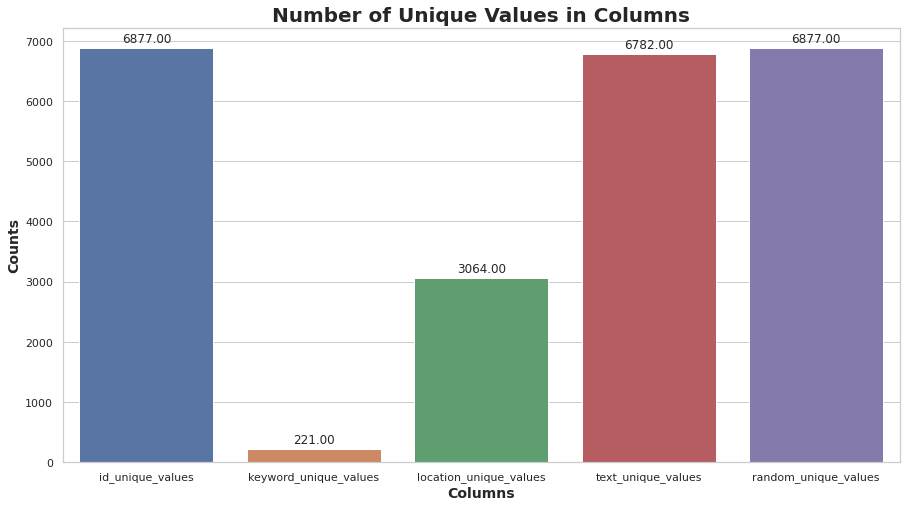

In [86]:
# creating a new dataframe for unique value cound
unique_values = dict(zip([col+"_unique_values" for col in tweets.columns if col != "target"],
                          [tweets[col].nunique() for col in tweets.columns if col != "target"]))
unique_values_df = pd.DataFrame(unique_values, index=[0])
unique_values_df = unique_values_df.melt(var_name= "columns", value_name= "counts")

# plotting unique values chart
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="counts", data=unique_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Number of Unique Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

**No of characters in a tweets**

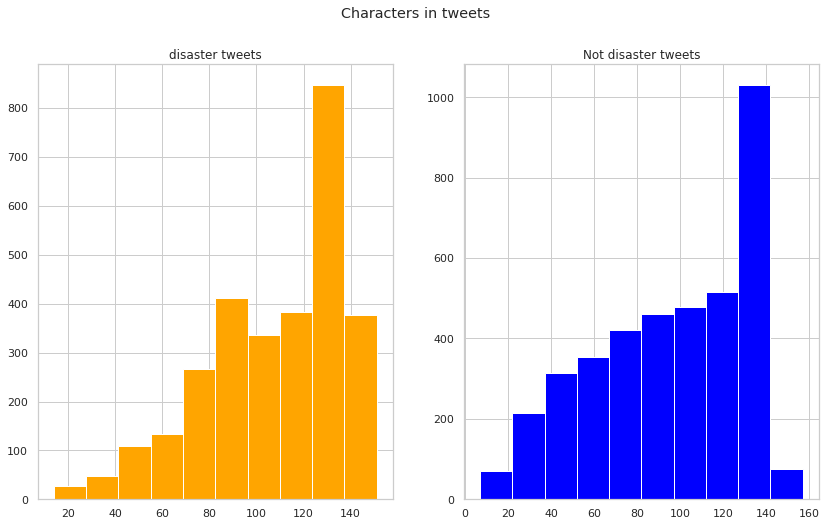

In [87]:
#No of characters in a tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,8))
tweet_len=tweets[tweets['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='orange')
ax1.set_title('disaster tweets')
tweet_len=tweets[tweets['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='blue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The no of characters for disaster tweets are 120-140 approximately.
The no of characters for normal tweets are 140-160 approximately.
The distribution looks almost same and not much difference.


**No of words in a tweet**

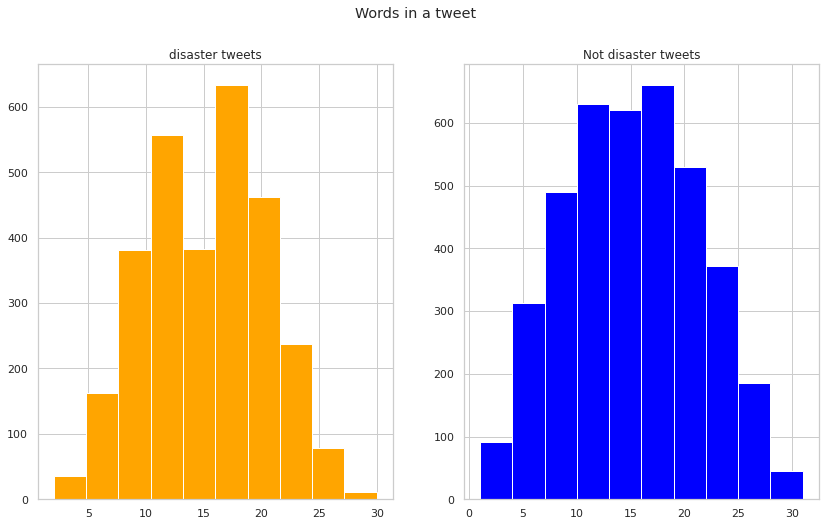

In [88]:
#No of words in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,8))
tweet_len=tweets[tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='orange')
ax1.set_title('disaster tweets')
tweet_len=tweets[tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='blue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Again the distribution normal tweets and disaster tweets are the same.

**Location break-up analysis**

There are lot of NaN values . The majority of the tweets are from USA.

In [89]:
#Location break-up analysis
tweets.location.value_counts()[:10].to_frame()

location
USA                    82
New York               66
United States          43
London                 41
Nigeria                26
UK                     24
Los Angeles, CA        23
India                  23
Mumbai                 21
Canada                 20

**Most common Words**

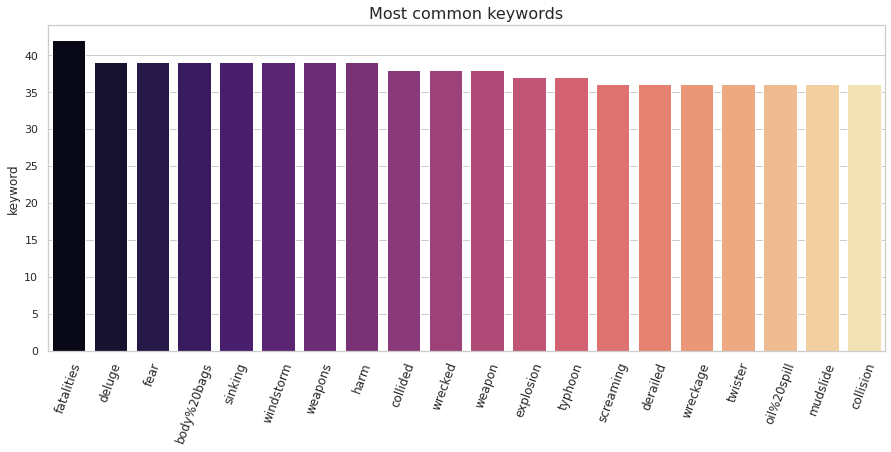

In [90]:
#Most common Words
common_keywords=tweets["keyword"].value_counts()[:20].to_frame()
fig=plt.figure(figsize=(15,6))
sns.barplot(data=common_keywords,x=common_keywords.index,y="keyword",palette="magma")
plt.title("Most common keywords",size=16)
plt.xticks(rotation=70,size=12);

In [91]:
common_keywords.head(20)

keyword
fatalities        42
deluge            39
fear              39
body%20bags       39
sinking           39
windstorm         39
weapons           39
harm              39
collided          38
wrecked           38
weapon            38
explosion         37
typhoon           37
screaming         36
derailed          36
wreckage          36
twister           36
oil%20spill       36
mudslide          36
collision         36

In [92]:
disaster_tweets = tweets[tweets['target']==1]['text']
non_disaster_tweets = tweets[tweets['target']==0]['text']

In [93]:
# keyword to target counts
keyword_count_df = pd.DataFrame(tweets.groupby(["keyword", "target"])["text"].count()).rename(columns={"text":"count"})
keyword_count_df.head(50)

count
keyword             target       
ablaze              0          19
                    1          12
accident            0          11
                    1          21
aftershock          0          31
airplane%20accident 0           5
                    1          28
ambulance           0          16
                    1          19
annihilated         0          21
                    1          11
annihilation        0          16
                    1           8
apocalypse          0          19
                    1           9
armageddon          0          28
                    1           5
army                0          28
                    1           3
arson               0           9
                    1          17
arsonist            0          23
                    1           8
attack              0           9
                    1          22
attacked            0          12
                    1          19
avalanche           0          23
                    1           4
battle              0          21
                    1           4
bioterror           0          13
                    1          21
bioterrorism        0           8
                    1          20
blaze               0          31
                    1           4
blazing             0          33
                    1           1
bleeding            0          26
                    1           5
blew%20up           0          28
                    1           1
blight              0          25
                    1           2
blizzard            0          30
                    1           4
blood               0          26
                    1           5
bloody              0          27

**Word Cloud**

Google says a word cloud is “an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.”So, the more often a specific word appears in your text, the bigger and bolder it appears in your word cloud. Wordcloud is used in a lot of applications like in the company website, try to extract from the customer feedback, employee feedback, etc.

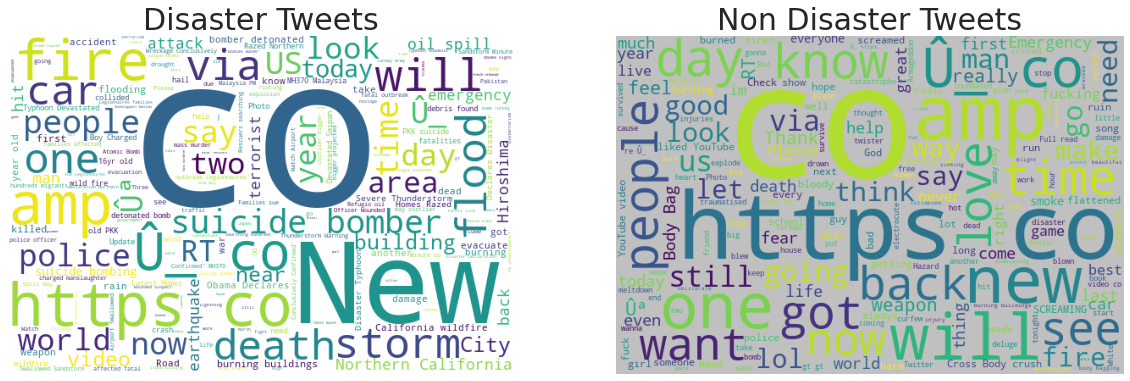

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=30);

wordcloud2 = WordCloud( background_color='silver',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=30);

In [95]:
def create_corpus(target):
    corpus=[]
    
    for x in tweets[tweets['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [96]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

**Common Stop Words used in the Tweets:**

<BarContainer object of 10 artists>

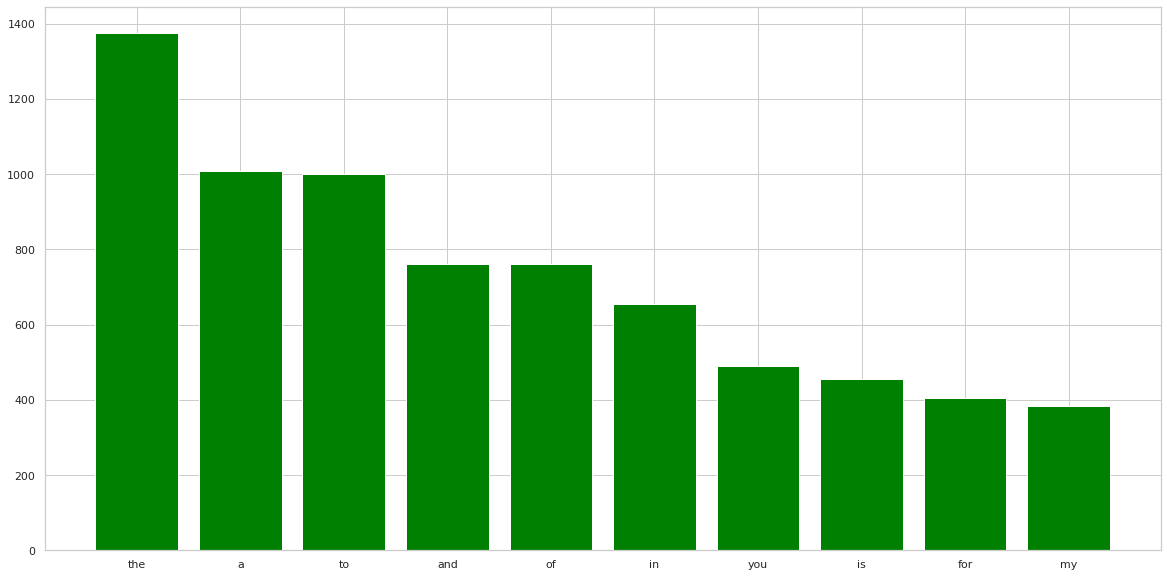

In [97]:
#
x,y=zip(*top)
plt.bar(x,y,color='green')

<BarContainer object of 10 artists>

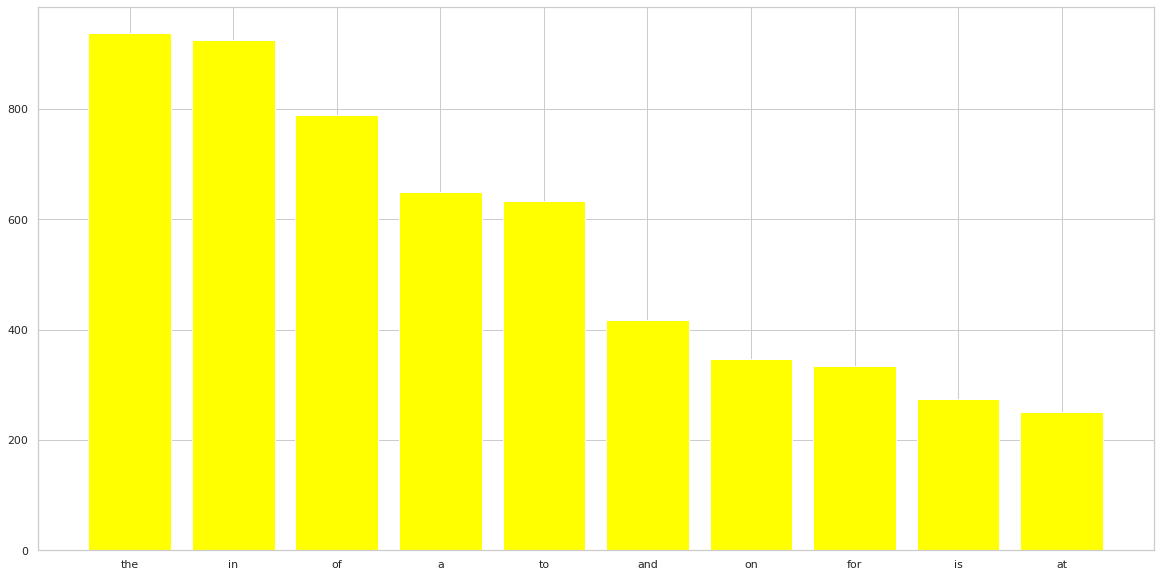

In [98]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y,color='yellow')

**N Grams Analysis:**
Bi grams
Tri grams

Unigrams are single words, bigrams are two words, trigrams are three words, 4-grams are four words, 5-grams are five words, etc.N-gram is simply a sequence of N words.

Some of the applications where N-grams used in NLP

* AutoComplete
* Auto Spell Check
* Check Grammar
* Virtual Assistant — Bots

In [99]:
#Bi grams and tri grams analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

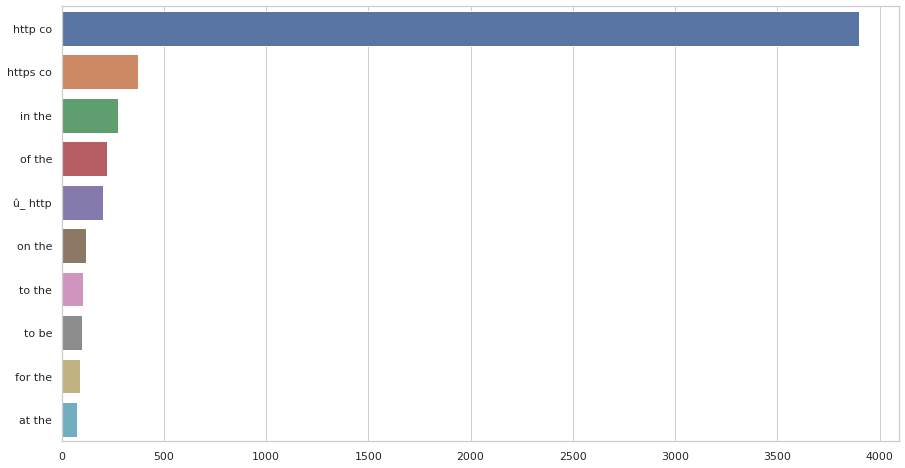

In [100]:
plt.figure(figsize=(15,8))
top_tweet_bigrams=get_top_tweet_bigrams(tweets['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [101]:
def get_top_tweet_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

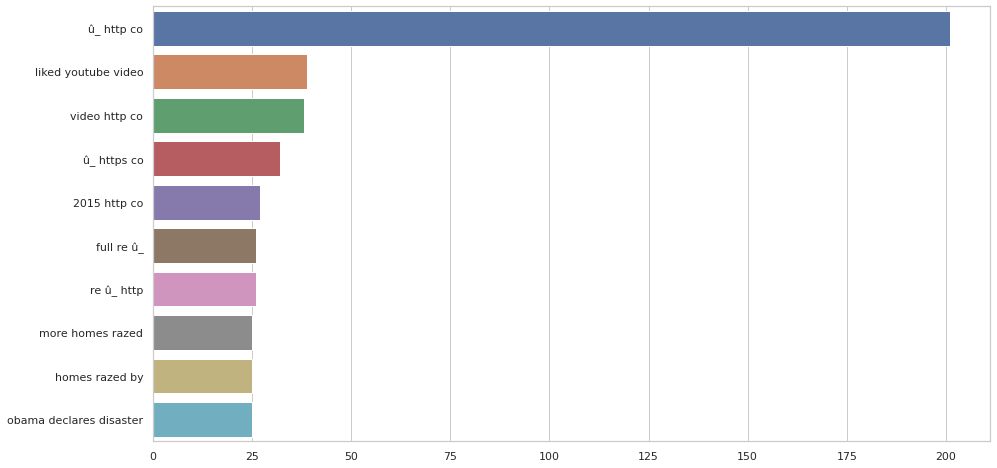

In [102]:
plt.figure(figsize=(15,8))
top_tweet_trigrams=get_top_tweet_trigrams(tweets['text'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
sns.barplot(x=y,y=x)

**Feature Engineering** 
* ID
* keyword
* Location
* text
* target
* random 

ID is not needed. It is unique and can be dropped.It won't help with the prediction.The same with random column. All values are unique and can be dropped.

There are lot of missing values for location and it won't help with the prediction. Hence the location can be dropped.

The only feature needed is text and the target column.


In [103]:
# check missing values
tweets.isnull().sum()

id             0
keyword       56
location    2294
text           0
target         0
random         0
dtype: int64

In [104]:
# all duplicate tweets
duplicated_df = tweets[tweets["text"].duplicated()]

print(f"Number of Duplicated Tweets in Train: {len(duplicated_df)}\n\
Number of Duplicated Tweets in Train: {duplicated_df['target'].notna().sum()}")


Number of Duplicated Tweets in Train: 95
Number of Duplicated Tweets in Train: 95


In [105]:
# add all the tweets with duplicates
train_duplicates = tweets[tweets["text"].duplicated()].groupby(["text"])[["target"]].agg(list)

diff_label_idx = []
for idx, val in enumerate(train_duplicates["target"]):
    for ele in val: 
        if ele != val[0]:
            diff_label_idx.append(idx)
                
print(f"Number of Duplicated Tweets with different target labels in train: {len(diff_label_idx)}")

Number of Duplicated Tweets with different target labels in train: 8


In [106]:
# tweets with different labels
train_duplicates.iloc[diff_label_idx]

target
text                                                               
#foodscare #offers2go #NestleIndia slips into l...           [1, 0]
CLEARED:incident with injury:I-495  inner loop ...           [0, 1]
He came to a land which was engulfed in tribal ...     [1, 0, 1, 0]
He came to a land which was engulfed in tribal ...     [1, 0, 1, 0]
Hellfire is surrounded by desires so be careful...           [0, 1]
The Prophet (peace be upon him) said 'Save your...  [0, 0, 0, 1, 0]
Who is bringing the tornadoes and floods. Who i...           [1, 0]
that horrible sinking feeling when youÛªve bee...        [0, 0, 1]

In [107]:
#Drop the columns
tweets.drop(columns = ['location', 'keyword', 'id', 'random'], inplace = True)
#tweets.drop(columns = ['location', 'keyword', 'id'], inplace = True)


In [108]:
tweets.head(5)


text  target
0  @randerson62 Watching news of wild fires and h...       1
1  Afghanistan: U.N. Reports 'Record-High Levels'...       1
2  @marksmaponyane Hey!Sundowns were annihilated ...       0
3  Gotta love #summer in #Calgary. #yyc #hailstor...       1
4  ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS Û...       1

In [109]:
tweets.shape[0]

6877

In [110]:
#tweets.drop_duplicates()
tweets.sort_values("text", inplace=True)
tweets.drop_duplicates(keep=False,inplace=True)
  
tweets.shape[0]

6738

In [111]:
def text_clear(data):
    tx = data.apply(lambda x: re.sub("http\S+", '', str(x)))
    tx = tx.apply(lambda x: re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '',x))
    tx = tx.apply(lambda x: re.sub(' +', ' ', x)) 
    tx = tx.apply(lambda x: re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', x)) 
    tx = tx.apply(lambda x: re.sub('(@[A-Za-z]+[A-za-z0-9-_]+)', '', x)) 
    tx = tx.apply(lambda x: re.sub('rt', '', x)) 
    tx = tx.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    return tx

In [112]:
clean_tweets=tweets
clean_tweets['text'] = text_clear(clean_tweets['text'])
clean_tweets.head()

text  target
2243   Residents Return To Destroyed Homes As Washin...       1
4203  360WiseNews  Chinas Stock Market Crash Are The...       1
1711  360WiseNews  Chinas Stock Market Crash Are The...       1
2555  360WiseNews  Chinas Stock Market Crash Are The...       0
2239  3 TITAN WarriorCord 100 Feet Authentic Militar...       0

In [113]:
test_tweets=df_test
test_tweets['text'] = text_clear(test_tweets['text'])
test_tweets.head()

text
0  Indian coast need to be prepared disaster read...
1  Unimaginable loss of lives and propey due to m...
2  For people living with disabilities preparing ...
3  When you go to make an iced coffee and realise...

**Model**

I used the following frameworks
* **Sci Kit Learn** - Logistic Regression
* **Tensorflow** - Transfer Learning - BERT Model
* **GCP - AutoMl**

# **BERT**
BERT stands for Bidirectional Encoder Representations from Transformers

BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.”

BERT is pre-trained on a large corpus of unlabelled text including the entire Wikipedia(that’s 2,500 million words!) and Book Corpus (800 million words).

BERT is a “deeply bidirectional” model. Bidirectional means that BERT learns information from both the left and the right side of a token’s context during the training phase.





In [114]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

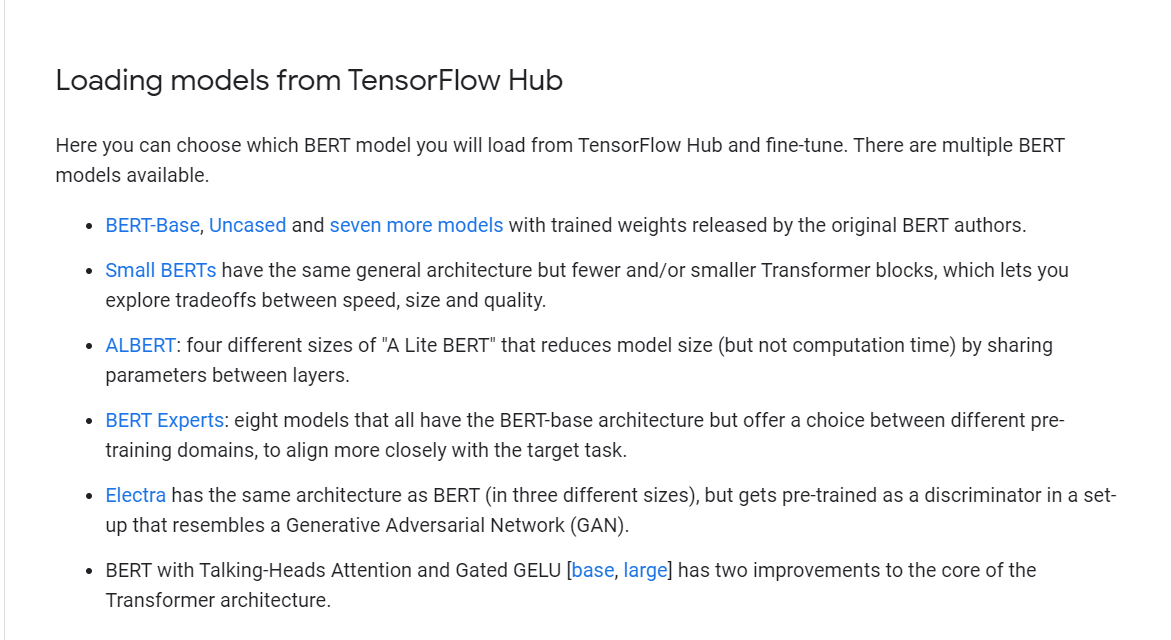

In [115]:
texts = clean_tweets['text']
target = clean_tweets['target']

train_input_ids, train_attention_masks = bert_encode(texts,90)

In [116]:
test_texts = df_test['text']
test_input_ids, test_attention_masks = bert_encode(test_texts,90)


In [117]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**Keras Sequential Model:**
* 2 Dense layer
* Introduce dropout - 0.2
* Loss: binary crossentropy because of binary classfication


In [118]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(90,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(90,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

**Loss function**

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), I will use BinaryCrossentropy loss function.

In [119]:
model = create_model(bert_model)

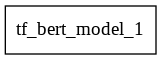

In [120]:
tf.keras.utils.plot_model(bert_model)

* EarlyStopping: Stop training when a monitored metric has stopped improving.

* ReduceLROnPlateau :Reduce learning rate when a metric has stopped improving.

In [121]:
stoped = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
redutor = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [122]:
history = model.fit([train_input_ids, train_attention_masks],
    target, validation_split=0.2, epochs=50, batch_size=32, callbacks=[stoped, redutor])

Epoch 1/50


169/169 [==============================] - ETA: 0s - loss: 0.5148 - accuracy: 0.7601WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


169/169 [==============================] - 81s 392ms/step - loss: 0.5148 - accuracy: 0.7601 - val_loss: 0.4032 - val_accuracy: 0.8346
Epoch 2/50
169/169 [==============================] - 64s 377ms/step - loss: 0.3871 - accuracy: 0.8427 - val_loss: 0.3772 - val_accuracy: 0.8338
Epoch 3/50
169/169 [==============================] - 64s 377ms/step - loss: 0.3333 - accuracy: 0.8722 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 4/50
169/169 [==============================] - 64s 377ms/step - loss: 0.2633 - accuracy: 0.9061 - val_loss: 0.4327 - val_accuracy: 0.8346
Epoch 5/50
169/169 [==============================] - 64s 377ms/step - loss: 0.2127 - accuracy: 0.9263 - val_loss: 0.4364 - val_accuracy: 0.8323
Epoch 6/50
169/169 [==============================] - 64s 377ms/step - loss: 0.1746 - accuracy: 0.9434 - val_loss: 0.4884 - val_accuracy: 0.8279
Epoch 7/50
169/169 [==============================] - 64s 377ms/step - loss: 0.1405 - accuracy: 0.9549 - val_loss: 0.5288 - val_accuracy: 0.8

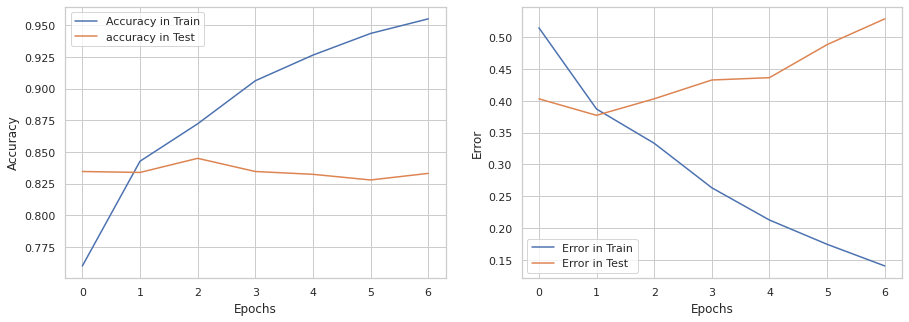

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Accuracy in Train','accuracy in Test'])
axes[0].grid(True)

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Error')
axes[1].legend(['Error in Train','Error in Test'])
axes[1].grid(True)


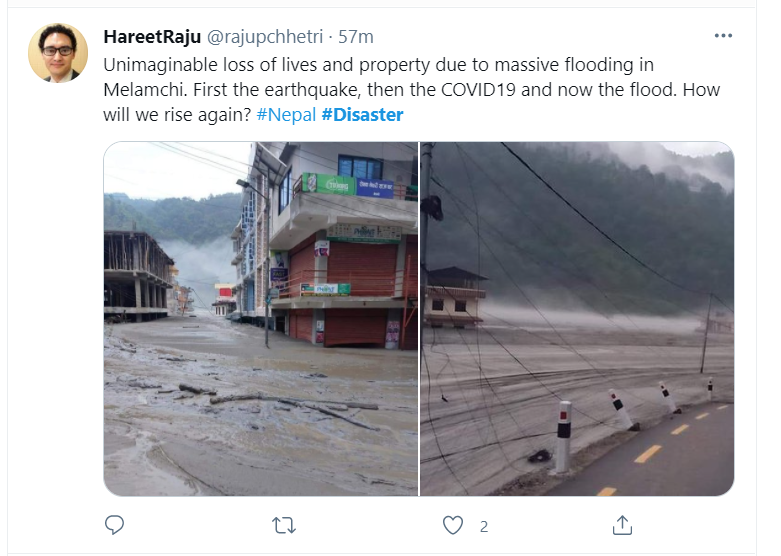

In [124]:
predictions = model.predict([test_input_ids, test_attention_masks])

In [125]:
#probs = model.predict(test_df["text"]) 
threshold = 0.5
preds = np.where(predictions[:,] > threshold, 1, 0)

In [126]:
print(preds)

[[1]
 [1]
 [1]
 [0]]


In [127]:
#!mkdir -p saved_model
export_dir='/content/saved_model'
tf.saved_model.save(bert_model, export_dir=export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/saved_model/assets


INFO:tensorflow:Assets written to: /content/saved_model/assets


In [128]:
reloaded = tf.saved_model.load(export_dir)

In [129]:
print(list(reloaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [130]:
infer = reloaded.signatures["serving_default"]
print(infer.structured_outputs)

{'last_hidden_state': TensorSpec(shape=(None, 5, 768), dtype=tf.float32, name='last_hidden_state'), 'pooler_output': TensorSpec(shape=(None, 768), dtype=tf.float32, name='pooler_output')}


In [131]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(clean_tweets['text'], 
                   
                                                    clean_tweets['target'], 
                                                    test_size = 0.2,
                                                    random_state = 10)

In [133]:
# Convert a collection of text documents to a matrix of token counts
tfidf = TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=5000,
                       norm='l2',
                       sublinear_tf=True)


In [134]:
train_features = tfidf.fit_transform(X_train).toarray()

In [135]:
print(train_features[1])
print(train_features.shape)

[0. 0. 0. ... 0. 0. 0.]
(5390, 5000)


In [136]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(1348, 5000)


In [137]:
train_labels = Y_train
test_labels = Y_test

In [138]:
mnb_classifier = MultinomialNB()

In [139]:
mnb_classifier.fit(train_features,train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [140]:
training_accuracy = accuracy_score(train_labels, mnb_classifier.predict(train_features))
print(training_accuracy)

0.862708719851577


In [141]:
 mnb_prediction = mnb_classifier.predict(test_features)

In [142]:
print(mnb_prediction)

[0 1 1 ... 0 0 0]


In [143]:
testing_accuracy = accuracy_score(test_labels, mnb_prediction)
print(testing_accuracy)

0.7856083086053413


In [144]:
print(classification_report(test_labels, mnb_prediction))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       777
           1       0.84      0.61      0.71       571

    accuracy                           0.79      1348
   macro avg       0.80      0.76      0.77      1348
weighted avg       0.80      0.79      0.78      1348



**AutoML**
AutoML enables developers with limited machine learning expertise to train high-quality models specific to their business needs. Build your own custom machine learning model in minutes.

AutoML Natural Language enables you to build and deploy custom machine learning models that analyze documents, categorizing them, identify entities within them, or assessing attitudes within them.



**Auto ML Steps:**

* ***Import the file and store it in a GCP bucket***
* ***Verfy the file contents***
* ***Train the model***
* ***Evaluate the model***
* ***Test and deploy the model***

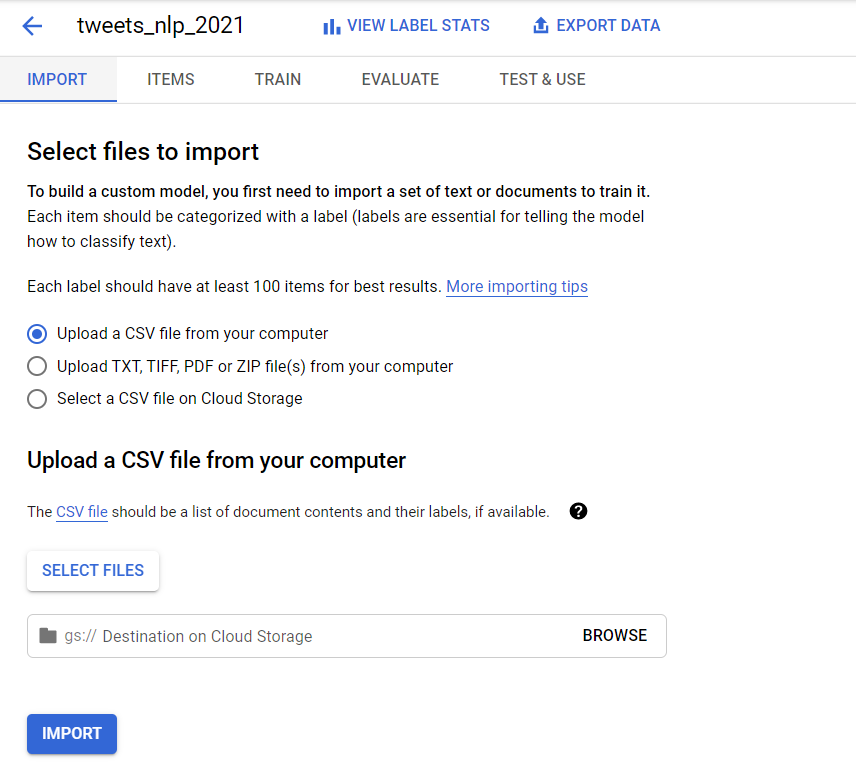

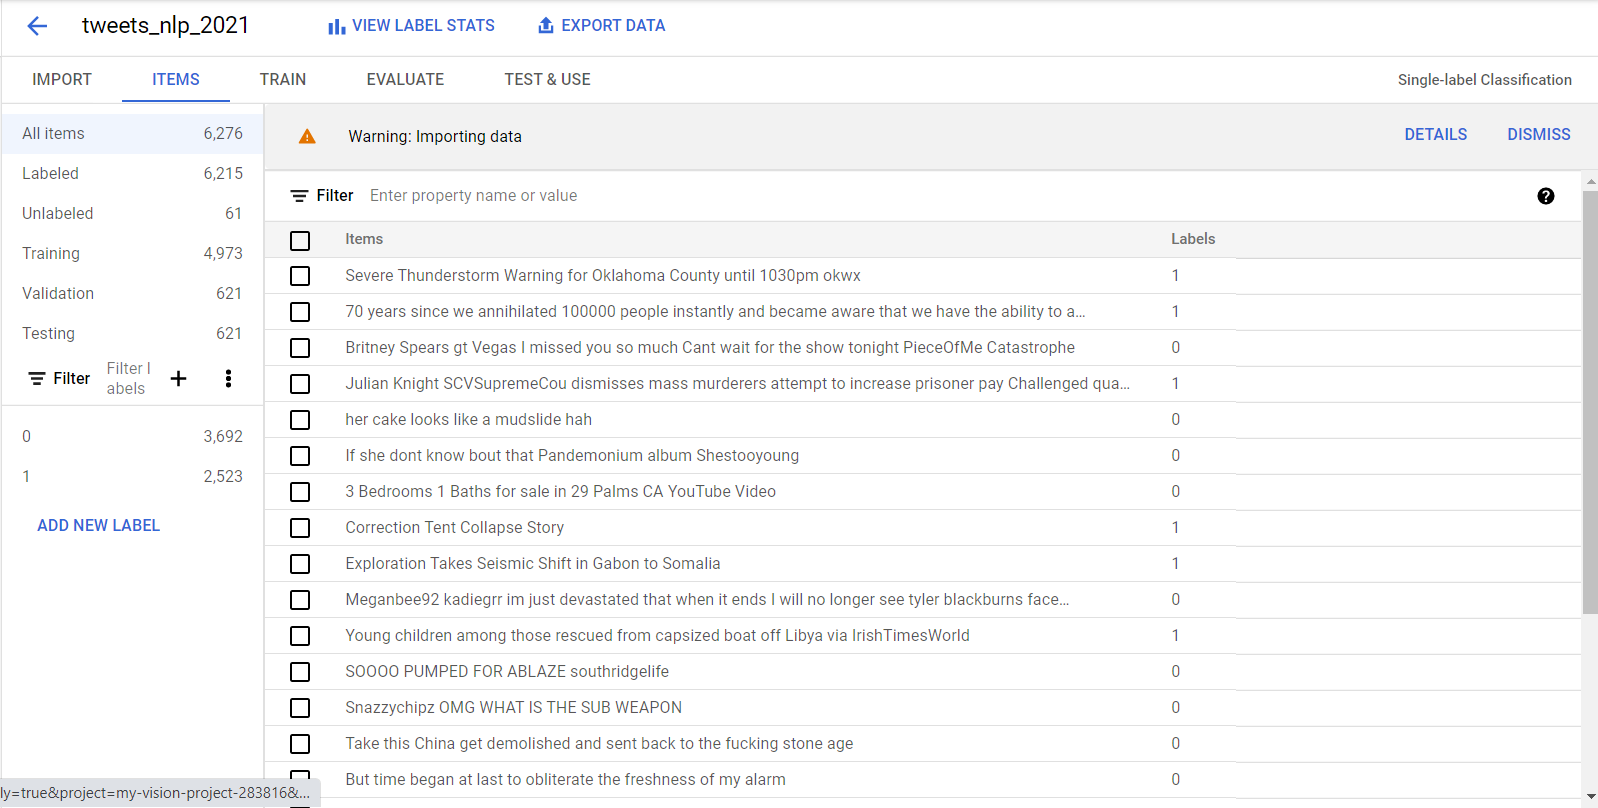

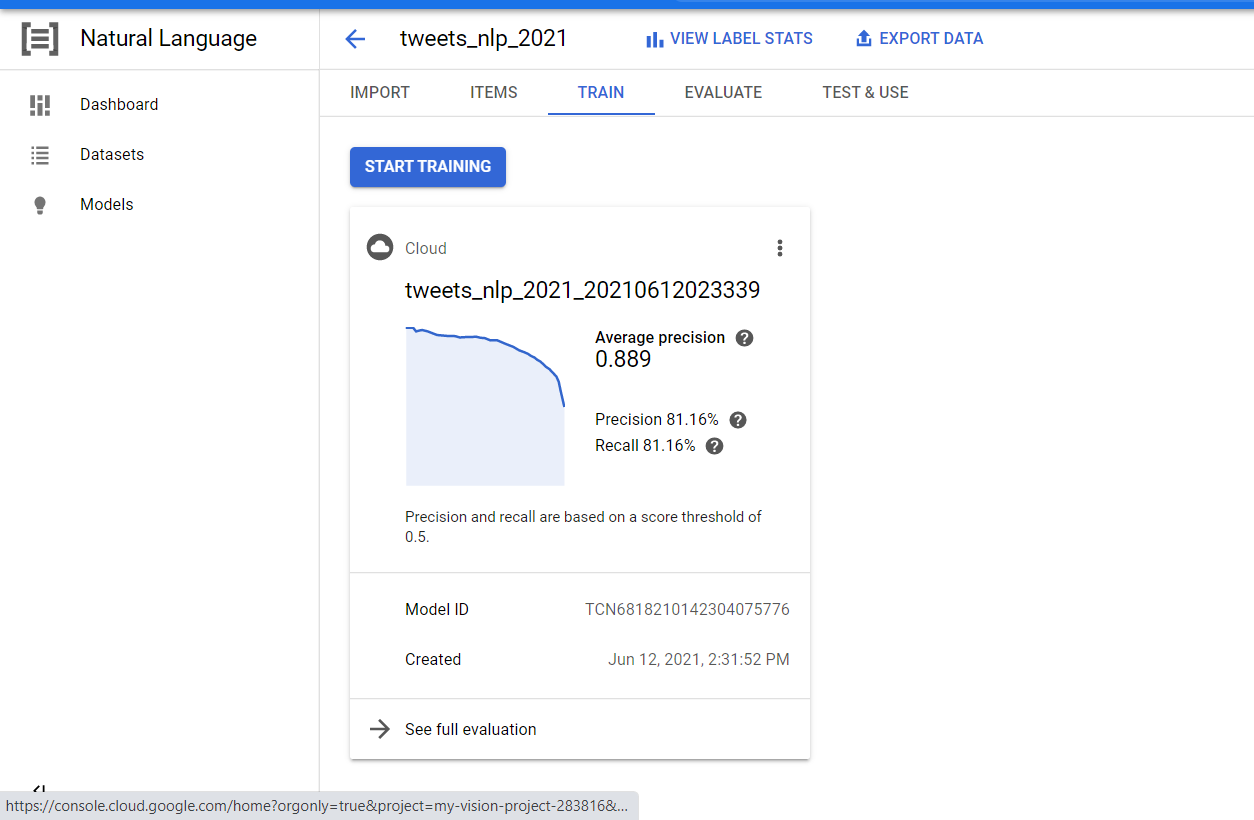

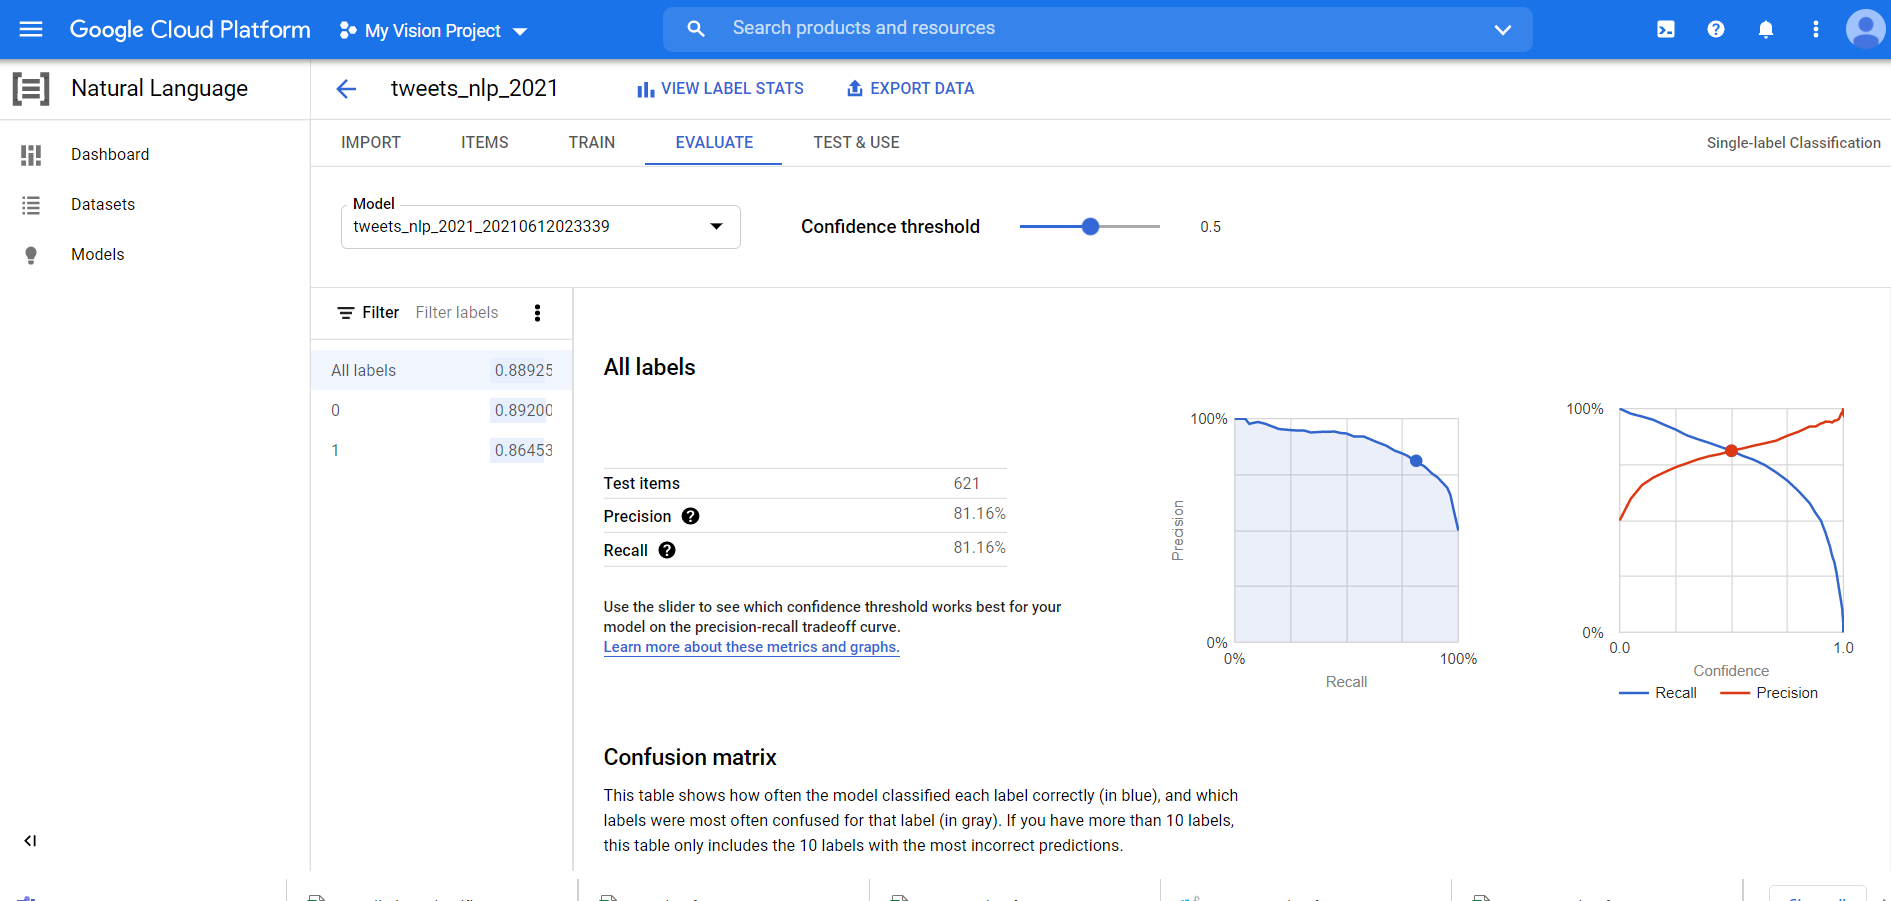

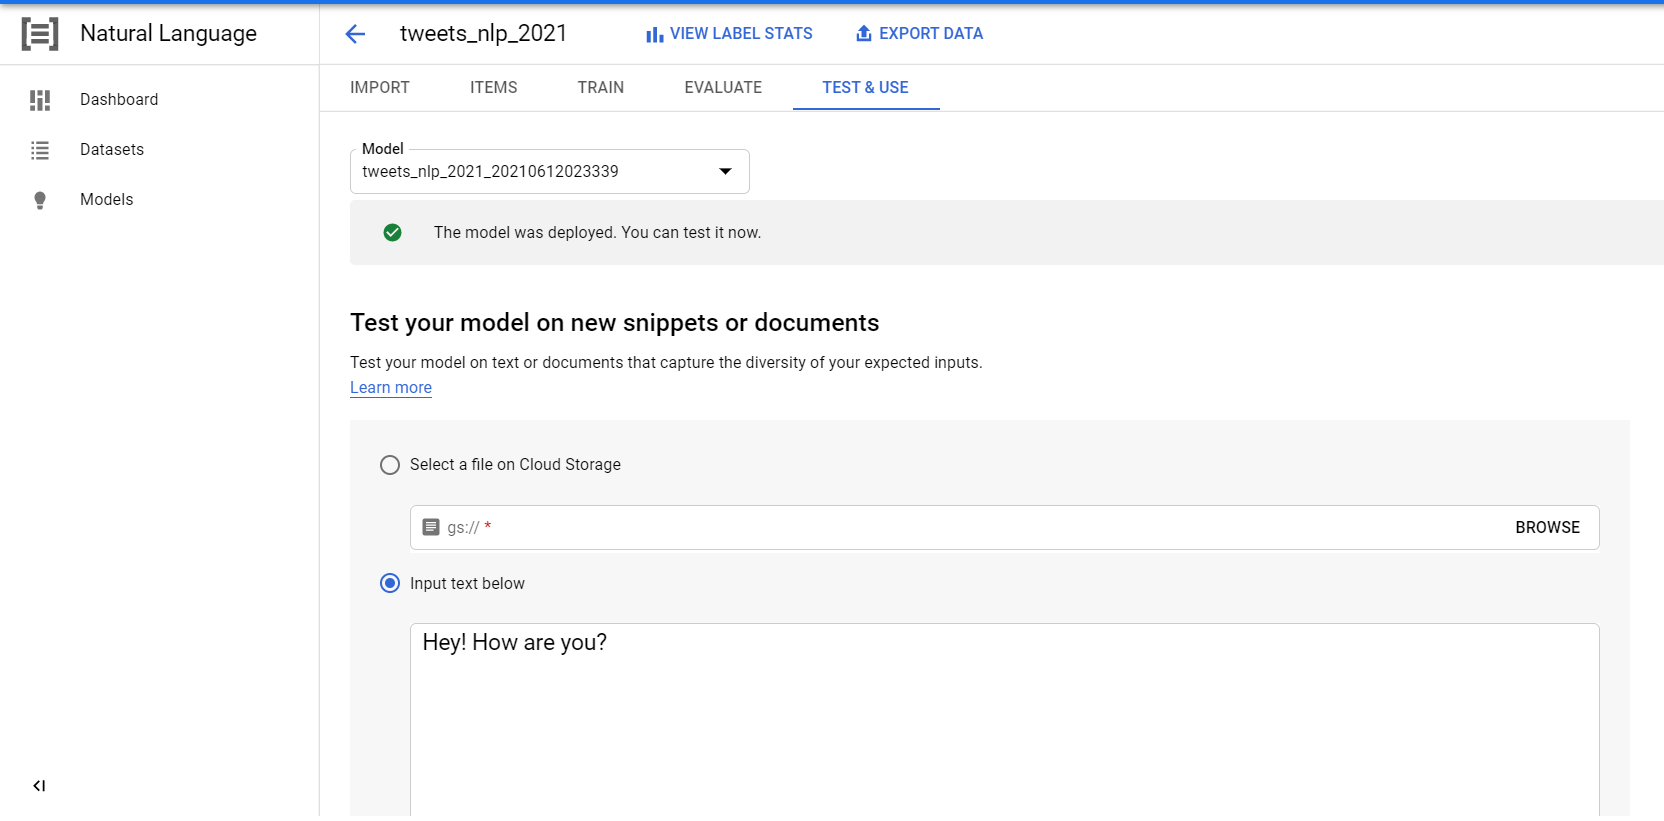

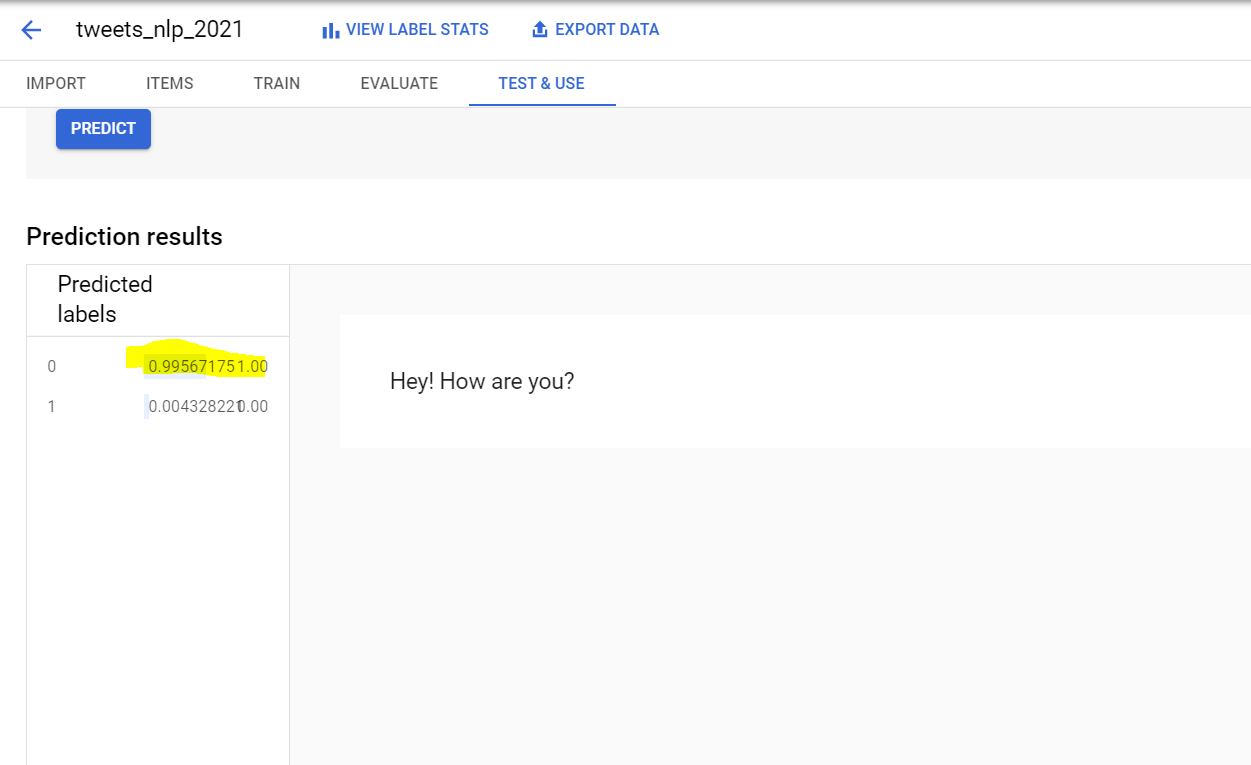

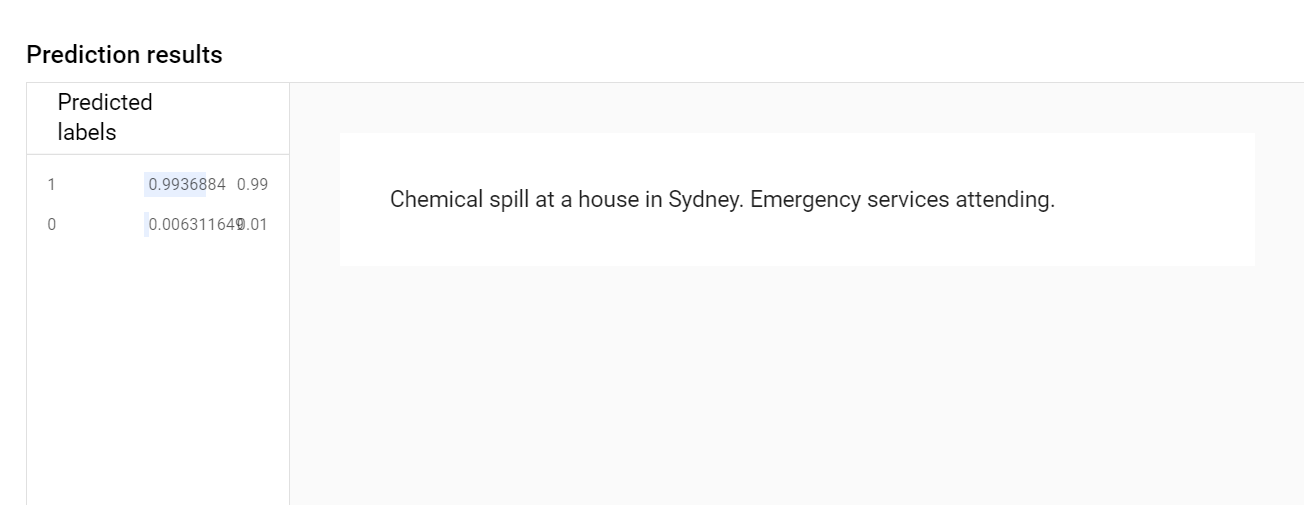

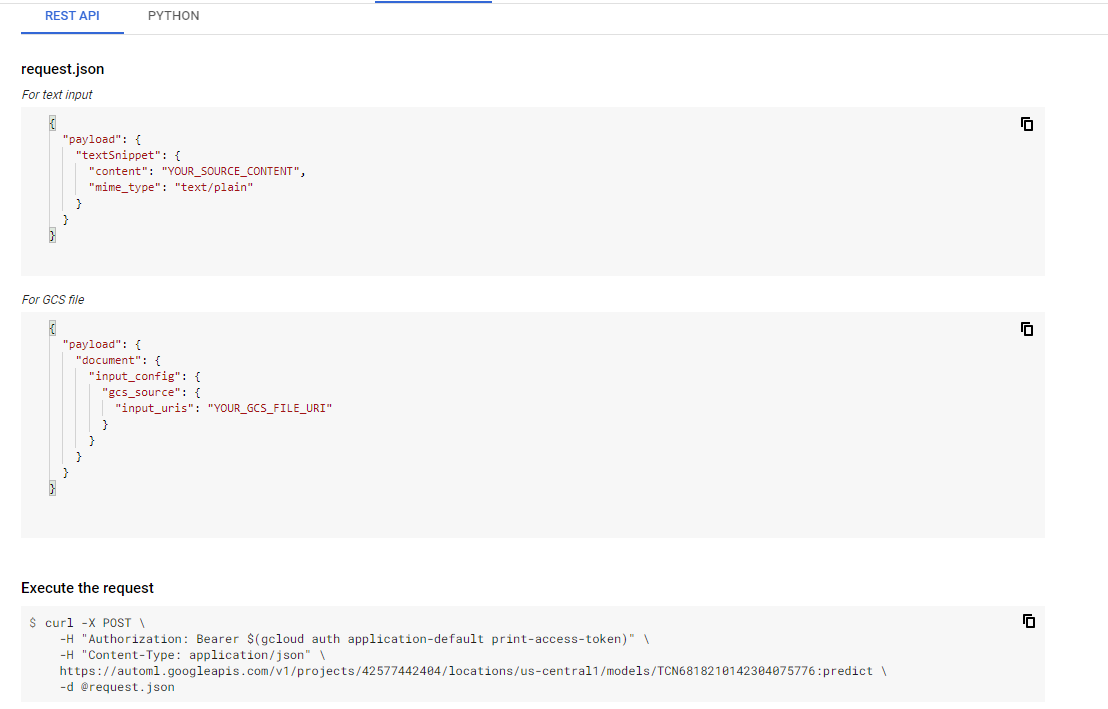

# **Conclusion:**


---


The Bert tensorflow model gave an accuracy of around 82%, the logictic regression gave around 78% and the automl model around 82%.

Again scope for improvements.
* try with multiple algorithms

* do hyper parameter tuning

* Increase the training set size.





# **References:**


---


1.[BERT Explained](http://jalammar.github.io/illustrated-bert/)

2.[Tensorflow - classify with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

3.[BERT Visual Guide](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

4.[Google AutoML - NLP API](https://cloud.google.com/natural-language/automl/docs)

5.[BERT used in all English Queries](https://searchengineland.com/google-bert-used-on-almost-every-english-query-342193)



# **Thank you for your time.**

---





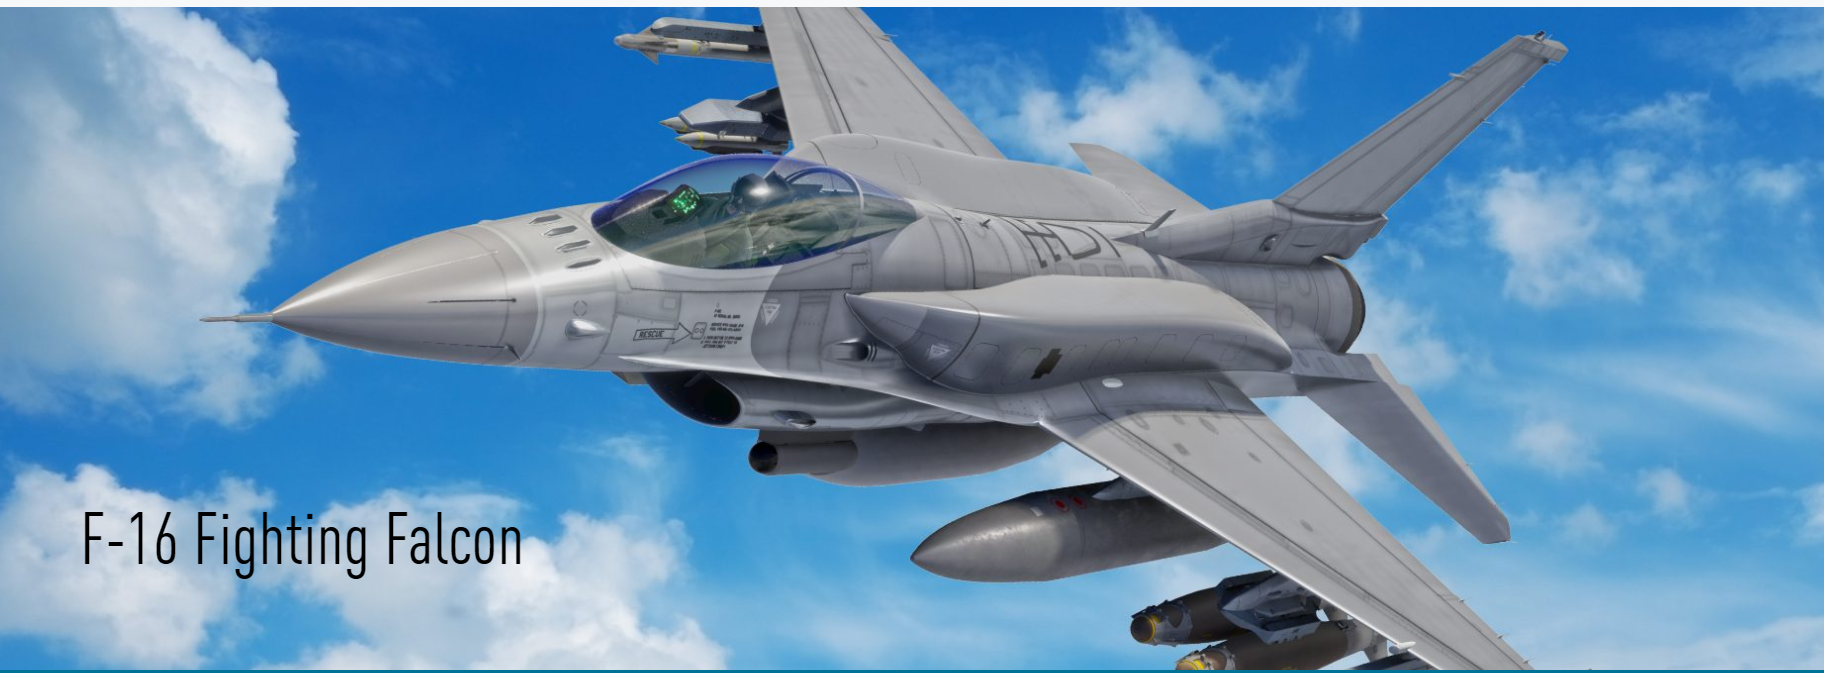

# **Questions Session**